In [1]:
!conda install pandas -y

Solving environment: done

# All requested packages already installed.



In [2]:
!pip install opencv-python torchsummary scikit-learn torchviz utils

Looking in indexes: http://mirrors.aliyun.com/pypi/simple


In [3]:
!conda install seaborn -y

Solving environment: done

# All requested packages already installed.



In [4]:
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision.utils as vutils
import utils
from torch.nn.functional import one_hot
from torchvision.utils import save_image
from torch.autograd import Variable
from torch.utils.data import SubsetRandomSampler

In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(torch.cuda.get_arch_list(), device)

['sm_37', 'sm_50', 'sm_60', 'sm_70', 'sm_75', 'sm_80', 'sm_86'] cuda


In [6]:
from __future__ import print_function
import argparse
import datetime
import matplotlib.pyplot as plt
from IPython.display import HTML
from IPython.display import clear_output
from tqdm import tqdm
import os
from tqdm import notebook
from sklearn.metrics import classification_report, confusion_matrix
import gc
import matplotlib.colors as mat_color
import numpy as np
from PIL import Image
import random
import cv2
from torchvision.datasets import ImageNet, ImageFolder
from torch.utils.data import DataLoader
from torchsummary import summary
from torchviz import make_dot

In [7]:
def initialize_weights(net):
    for m in net.modules():
        if isinstance(m, nn.Conv2d):
            m.weight.data.normal_(0, 0.02)
            m.bias.data.zero_()
        elif isinstance(m, nn.ConvTranspose2d):
            m.weight.data.normal_(0, 0.02)
            m.bias.data.zero_()
        elif isinstance(m, nn.Linear):
            m.weight.data.normal_(0, 0.02)
            m.bias.data.zero_()

class Generator(nn.Module):
    # Network Architecture is exactly same as in infoGAN (https://arxiv.org/abs/1606.03657)
    # Architecture : FC1024_BR-FC7x7x128_BR-(64)4dc2s_BR-(1)4dc2s_S
    def __init__(self, input_dim=100, output_dim=1, input_size=32, class_num=10):
        super(Generator, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.input_size = input_size
        self.class_num = class_num

        self.fc = nn.Sequential(
            nn.Linear(self.input_dim + self.class_num, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Linear(1024, 128 * (self.input_size // 4) * (self.input_size // 4)),
            nn.BatchNorm1d(128 * (self.input_size // 4) * (self.input_size // 4)),
            nn.ReLU(),
        )
        self.deconv = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 4, 2, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, self.output_dim, 4, 2, 1),
            nn.Tanh(),
        )
        initialize_weights(self)

    def forward(self, input, label):
        x = torch.cat([input, label], 1)
        x = self.fc(x)
        x = x.view(-1, 128, (self.input_size // 4), (self.input_size // 4))
        x = self.deconv(x)

        return x

    
class Discriminator(nn.Module):
    # Network Architecture is exactly same as in infoGAN (https://arxiv.org/abs/1606.03657)
    # Architecture : (64)4c2s-(128)4c2s_BL-FC1024_BL-FC1_S
    def __init__(self, input_dim=1, output_dim=1, input_size=32, class_num=10):
        super(Discriminator, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.input_size = input_size
        self.class_num = class_num

        self.conv = nn.Sequential(
            nn.Conv2d(self.input_dim, 64, 4, 2, 1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, 4, 2, 1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
        )
        self.fc1 = nn.Sequential(
            nn.Linear(128 * (self.input_size // 4) * (self.input_size // 4), 1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(0.2),
        )
        self.dc = nn.Sequential(
            nn.Linear(1024, self.output_dim),
            nn.Sigmoid(),
        )
        self.cl = nn.Sequential(
            nn.Linear(1024, self.class_num),
        )
        initialize_weights(self)

    def forward(self, input):
        x = self.conv(input)
        x = x.view(-1, 128 * (self.input_size // 4) * (self.input_size // 4))
        x = self.fc1(x)
        d = self.dc(x)
        c = self.cl(x)

        return d, c


In [8]:
base_path = './data'
base_folder = "Covid-19 Image Dataset"
classic_folder = 'Coivd-19_Classic'
synthetic_folder = 'Coivd-19_Synthetic'
data_dir = os.path.join(base_path, classic_folder)

In [9]:
batch_size = 32
train_path = os.path.join(data_dir, "train")
test_path = os.path.join(data_dir, "test")

In [10]:
labels = os.listdir(train_path)
print(labels)
no_norm = mat_color.Normalize(vmin=0, vmax=255, clip=False)
label_dict = {
    0 : 'Covid', 
    1 : 'Normal', 
    2 : 'Viral Pneumonia'
}

['Covid', 'Normal', 'Viral Pneumonia']


In [11]:
I_want_to_train_faster = 50

In [12]:
# Number of training epochs
num_epochs = round(1000/I_want_to_train_faster)
#All images will be resized to this size using a transformer.
img_size = 128 * 2
# Number of channels in the training images. For color images this is 3
nc = 3
# Size of z latent vector (i.e. size of generator input)
nz = img_size
# Size of feature maps in generator
ngf = img_size
# Size of feature maps in discriminator
ndf = img_size
# No of labels
nb_label = len(labels)
# Learning rate for optimizers
lr = 0.00000002 * I_want_to_train_faster
lr_d = 0.00000002 * I_want_to_train_faster
# Beta1 hyperparam for Adam optimizers
beta1 = 0.5
# Beta2 hyperparam for Adam optimizers
beta2 = 0.999

real_label = 1.
fake_label = 0.
s_criterion = nn.BCELoss().to(device) #For synthesizing
c_criterion = nn.CrossEntropyLoss().to(device) #For classification

s_label = torch.FloatTensor(batch_size).to(device)
c_label = torch.FloatTensor(batch_size, nb_label).to(device)
noise = torch.FloatTensor(batch_size, nz).to(device)

s_label = Variable(s_label)
c_label = Variable(c_label)
print(s_label.shape)
print(c_label.shape)
print(noise.shape)

noise = Variable(noise)

noise_fixed = torch.FloatTensor(3, nz).to(device)
noise_data = np.random.normal(0, 1, (3, nz))
noise_fixed.data.copy_(torch.tensor(noise_data))
noise_fixed = Variable(noise_fixed)

label_fixed = torch.FloatTensor(3, 3).to(device)
label_onehot = np.zeros((3, nb_label))
label_fixed_data = [0, 1, 2]
label_onehot[np.arange(1), label_fixed_data] = 1
label_fixed.data.copy_(torch.tensor(label_onehot))
label_fixed = Variable(label_fixed)

print(noise_fixed.shape)
print(label_fixed.shape)

torch.Size([32])
torch.Size([32, 3])
torch.Size([32, 256])
torch.Size([3, 256])
torch.Size([3, 3])


In [13]:
for func in [
    lambda: os.mkdir(os.path.join('.', 'GANAug')),
    lambda: os.mkdir(os.path.join('.', 'GANAug/model')),
    lambda: os.mkdir(os.path.join('.', 'GANAug/plots')),
    lambda: os.mkdir(os.path.join('.', 'GANAug/model/ACGAN')),
    lambda: os.mkdir(os.path.join('.', 'GANAug/plots/ACGAN')),
    lambda: os.mkdir(os.path.join('.', 'GANAug/output_images')),
    lambda: os.mkdir(os.path.join('.', 'GANAug/output_images/ACGAN')),
    lambda: os.mkdir(os.path.join('.', 'GANAug/output_images/ACGAN/' + label_dict[0])),
    lambda: os.mkdir(os.path.join('.', 'GANAug/output_images/ACGAN/' + label_dict[1])),
    lambda: os.mkdir(os.path.join('.', 'GANAug/output_images/ACGAN/' + label_dict[2]))]:  # create directories
    try:
        func()
    except Exception as error:
        print(error)
        continue

In [14]:
matrix_fields = [
    'G_losses',
    'G_class_losses',
    'G_syn_losses',
    'D_losses',
    'D_real_losses',
    'D_fake_losses',
    'D_class_losses',
    'D_syn_losses',
    'Accuracy',
    'Losses'
]
metrics = {field: list() for field in matrix_fields}

In [15]:
def load_dataset(train_dir=train_path, test_dir=test_path):
    transform = transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])
    train_data = datasets.ImageFolder(train_dir, transform=transform)
    train_loader = DataLoader(train_data, batch_size, shuffle=True, num_workers=1)

    test_data = datasets.ImageFolder(test_dir ,transform=transform)
    test_loader = DataLoader(test_data, batch_size, shuffle=True, num_workers=1)

    return train_loader, test_loader, train_data, test_data

In [16]:
train_loader, test_loader, train_data, test_data = load_dataset()

In [17]:
generator = Generator(input_dim=nz, output_dim=nc, input_size=ngf, class_num=nb_label).to(device)
discriminator = Discriminator(input_dim=nc, output_dim=1, input_size=ndf, class_num=nb_label).to(device)

# setup optimizer
optimizerD = optim.Adam(discriminator.parameters(), lr=lr_d, betas=(beta1, beta2))
optimizerG = optim.Adam(generator.parameters(), lr=lr, betas=(beta1, beta2))

In [18]:
g_output = generator(torch.rand((batch_size, nz)).to(device), torch.ones((batch_size, nb_label)).to(device))
print(g_output.shape)

torch.Size([32, 3, 256, 256])


In [19]:
s_output, c_output = discriminator(torch.rand(g_output.shape).to(device))
print(s_output.shape)
print(c_output.shape)
del g_output, s_output, c_output

torch.Size([32, 1])
torch.Size([32, 3])


In [20]:
!pip install torchviz

Looking in indexes: http://mirrors.aliyun.com/pypi/simple


In [21]:
print(generator)
print(discriminator)

Generator(
  (fc): Sequential(
    (0): Linear(in_features=259, out_features=1024, bias=True)
    (1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=1024, out_features=524288, bias=True)
    (4): BatchNorm1d(524288, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
  )
  (deconv): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (4): Tanh()
  )
)
Discriminator(
  (conv): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_runni

In [22]:
SHOW = True
if SHOW:
    summary(generator, [[nz], [nc]], batch_size=16, device=device)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [16, 1024]         266,240
       BatchNorm1d-2                 [16, 1024]           2,048
              ReLU-3                 [16, 1024]               0
            Linear-4               [16, 524288]     537,395,200
       BatchNorm1d-5               [16, 524288]       1,048,576
              ReLU-6               [16, 524288]               0
   ConvTranspose2d-7         [16, 64, 128, 128]         131,136
       BatchNorm2d-8         [16, 64, 128, 128]             128
              ReLU-9         [16, 64, 128, 128]               0
  ConvTranspose2d-10          [16, 3, 256, 256]           3,075
             Tanh-11          [16, 3, 256, 256]               0
Total params: 538,846,403
Trainable params: 538,846,403
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.05


In [23]:
if SHOW:
    summary(discriminator, (nc, img_size, img_size), batch_size=16, device=device)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [16, 64, 128, 128]           3,136
         LeakyReLU-2         [16, 64, 128, 128]               0
            Conv2d-3          [16, 128, 64, 64]         131,200
       BatchNorm2d-4          [16, 128, 64, 64]             256
         LeakyReLU-5          [16, 128, 64, 64]               0
            Linear-6                 [16, 1024]     536,871,936
       BatchNorm1d-7                 [16, 1024]           2,048
         LeakyReLU-8                 [16, 1024]               0
            Linear-9                    [16, 1]           1,025
          Sigmoid-10                    [16, 1]               0
           Linear-11                    [16, 3]           3,075
Total params: 537,012,676
Trainable params: 537,012,676
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 12.00

In [24]:
SHOW_IMG = False
if SHOW_IMG:
    def modeltorchviz(model, input_1, input_2):
        if input_2 != None:
            y = model(input_1.to(device), input_2.to(device))
        else:
            y = model(input_1to(device))
        if input_2 != None:
            MyConvNetVis = make_dot(y, params=dict(list(model.named_parameters()) + [('x', input_1)] + [('x', input_2)]))
        else:
            MyConvNetVis = make_dot(y, params=dict(list(model.named_parameters()) + [('x', input_1)]))
        MyConvNetVis.format = "png"
        MyConvNetVis.directory = "images"
        MyConvNetVis.view() 

In [25]:
if SHOW_IMG:
    modeltorchviz(generator, torch.randn(16, nz).requires_grad_(True), torch.randn(16, nb_label).requires_grad_(True))

In [26]:
if SHOW_IMG:
    modeltorchviz(discriminator, torch.randn(1, nc, ndf, ndf).requires_grad_(True))

In [27]:
def test(predict, labels):
    correct = 0
    predict = torch.argmax(predict, dim=1)
    labels = torch.argmax(labels, dim=1)
    correct = predict.eq(labels.data).cpu().sum()
    return correct, len(labels.data)

In [28]:
early_stop_count = 0
early_stop_patient = len(train_loader) * 42
early_stop = False
best_batch_loss = -1
save_model = False
print(early_stop_patient)

7938


In [29]:
def get_file_list(file_path, length):
    dir_list = os.listdir(file_path)
    dir_list = only_pth_file(dir_list)
    if not dir_list:
        return
    else:
        dir_list = sorted(dir_list,  key=lambda x: os.path.getmtime(os.path.join(file_path, x)))
        print("files to be deleted < length =", length ,"> ->", dir_list[0:length])
        return dir_list[0:length]

In [30]:
def only_pth_file(file_list):
    new_list = []
    for file in file_list:
        if file[-4:] == ".pth":
            new_list.append(file)
    return new_list

In [31]:
number_of_model_saved = 10

In [32]:
for epoch in range(num_epochs):
    epoch += 1
    log_in_data_loader = []
    for i, data in enumerate(tqdm(train_loader, 0)):
        ###########################
        # (1) Update D network
        ###########################
        # train with real
        discriminator.zero_grad()
        img, label = data
        batch_size = img.size(0)
        with torch.no_grad():
            img, label = img.to(device), label.to(device)
            label = one_hot(label, num_classes=nb_label)
            s_label.resize_(batch_size).fill_(real_label)
            c_label.resize_(batch_size, 3).copy_(label)
        s_output, c_output = discriminator(img)
        s_errD_real = s_criterion(s_output[:,0], s_label.resize_(batch_size))
        c_errD_real = c_criterion(c_output, c_label)
        errD_real = s_errD_real + c_errD_real
        errD_real_original = errD_real
        errD_real.backward()
        
        correct, length = test(c_output, c_label)

        # train with fake
        noise_data = np.random.normal(0, 1, (batch_size, nz))
        noise.resize_(batch_size, nz).data.copy_(torch.tensor(noise_data))
        label = np.random.randint(0, nb_label, batch_size)
        noise_ = np.random.normal(0, 1, (batch_size, nz))
        label_onehot = np.zeros((batch_size, nb_label))
        label_onehot[np.arange(batch_size), label] = 1
        c_label.resize_(batch_size, nb_label).data.copy_(torch.tensor(label_onehot))
        fake = generator(noise, c_label)
        s_label.data.fill_(fake_label)
        s_output,c_output = discriminator(fake)
        s_errD_fake = s_criterion(s_output[:,0], s_label.resize_(batch_size))
        c_errD_fake = c_criterion(c_output, c_label)
        errD_fake = s_errD_fake + c_errD_fake
        errD_fake_original = errD_fake
        errD_fake.backward()

        errD = errD_real_original + errD_fake_original
        optimizerD.step()

        ###########################
        # (2) Update G network
        ###########################
        generator.zero_grad()
        s_label.resize_(batch_size, 1).data.fill_(real_label)
        fake = generator(noise, c_label)
        s_output, c_output = discriminator(fake)
        s_errG = s_criterion(s_output[:,0], s_label.resize_(batch_size))
        c_errG = c_criterion(c_output, c_label)

        errG = s_errG + c_errG
        errG_original = errG
        errG.backward()
        optimizerG.step()
        metrics['G_losses'].append(errG_original.item())
        metrics['G_class_losses'].append(c_errG.item())
        metrics['G_syn_losses'].append(s_errG.item())
        metrics['D_losses'].append(errD.item())
        metrics['D_real_losses'].append(errD_real_original.item())
        metrics['D_fake_losses'].append(errD_fake_original.item())
        metrics['D_class_losses'].append((c_errD_real + c_errD_fake).item())
        metrics['D_syn_losses'].append((s_errD_real + s_errD_fake).item())
        metrics['Losses'].append((errG + errD).item())
        metrics['Accuracy'].append(correct/length)
    
        if best_batch_loss < 0:
            best_batch_loss = (errG_original + errD).item()
            early_stop_count = 0
        else:
            if best_batch_loss >= (errG_original + errD).item():
                best_batch_loss = (errG_original + errD).item()
                early_stop_count = 0
                log_in_data_loader.append("---------------------<lowest loss update -> " + str(best_batch_loss) + " at -> " + str(i + 1) + ">---------------------")
                save_model = True
            else:
                early_stop_count += 1
                if early_stop_count >= early_stop_patient:
                    log_in_data_loader.append("-----------------------------------< early stopping ... >-----------------------------------")
                    early_stop = True
        
        if i % round(len(train_loader)/5) == 0:
            vutils.save_image(img, './GANAug/output_images/ACGAN/real_samples_e' + str(epoch) + '_d' + str(i) + '.jpg', normalize=True)
            fake = generator(noise_fixed, label_fixed)
            for j in range(len(fake)):
                vutils.save_image(fake[j].data,
                        '%s/fake_samples_epoch_%03d.jpg' % ('./GANAug/output_images/ACGAN/' + label_dict[label_fixed_data[j]], epoch), 
                                  normalize=True)
    for message in log_in_data_loader:
        print(message)
    print('[%d/%d] ======================== Loss_D: %.8f, Loss_G: %.8f, Accuracy: %.8f\nLoss_S_D: %.8f, Loss_C_D: %.8f, Loss_R_D: %.8f, Loss_F_D: %.8f\nLoss_S_G: %.8f, Loss_C_G: %.8f ================================================'
          % (epoch, num_epochs, 
             np.mean(metrics['D_losses'][-len(train_loader):]), 
             np.mean(metrics['G_losses'][-len(train_loader):]),
             np.mean(metrics['Accuracy'][-len(train_loader):]),
             np.mean(metrics['D_syn_losses'][-len(train_loader):]), 
             np.mean(metrics['D_class_losses'][-len(train_loader):]), 
             np.mean(metrics['D_real_losses'][-len(train_loader):]), 
             np.mean(metrics['D_fake_losses'][-len(train_loader):]), 
             np.mean(metrics['G_syn_losses'][-len(train_loader):]),
             np.mean(metrics['G_class_losses'][-len(train_loader):])))

    # do checkpointing
    if save_model == True:
        save_model = False
        torch.save(generator.state_dict(), '%s/G_epoch_%d_save_model.pth' % (os.path.join('.', 'GANAug/model/ACGAN'), epoch))
        torch.save(discriminator.state_dict(), '%s/D_epoch_%d_save_model.pth' % (os.path.join('.', 'GANAug/model/ACGAN'), epoch))
    elif early_stop:
        torch.save(generator.state_dict(), '%s/G_epoch_%d_early_stop.pth' % (os.path.join('.', 'GANAug/model/ACGAN'), epoch))
        torch.save(discriminator.state_dict(), '%s/D_epoch_%d_early_stop.pth' % (os.path.join('.', 'GANAug/model/ACGAN'), epoch))
        break
    elif epoch % round(num_epochs/10) == 0:
        torch.save(generator.state_dict(), '%s/G_epoch_%d.pth' % (os.path.join('.', 'GANAug/model/ACGAN'), epoch))
        torch.save(discriminator.state_dict(), '%s/D_epoch_%d.pth' % (os.path.join('.', 'GANAug/model/ACGAN'), epoch))
    else:
        print("---------------------< no model saved at epoch:", epoch, ">---------------------")
    
    if len(only_pth_file(os.listdir(os.path.join('.', 'GANAug/model/ACGAN')))) > number_of_model_saved:
        delete_list = get_file_list(os.path.join('.', 'GANAug/model/ACGAN'), 
                                    len(only_pth_file(os.listdir(os.path.join('.', 'GANAug/model/ACGAN')))) - number_of_model_saved)
        for file in delete_list:
            if os.path.exists(os.path.join(os.path.join('.', 'GANAug/model/ACGAN'), file)):
                os.remove(os.path.join(os.path.join('.', 'GANAug/model/ACGAN'), file))
            else:
                print("file ->", os.path.join(os.path.join('.', 'GANAug/model/ACGAN'), file), "does not exist")

100%|██████████████████████████████████████████████████████████████████████████████████████| 189/189 [04:36<00:00,  1.47s/it]


---------------------<lowest loss update -> 5.35512113571167 at -> 2>---------------------
---------------------<lowest loss update -> 5.245800971984863 at -> 5>---------------------
---------------------<lowest loss update -> 5.241637706756592 at -> 6>---------------------
---------------------<lowest loss update -> 5.1464715003967285 at -> 7>---------------------
---------------------<lowest loss update -> 5.138365745544434 at -> 12>---------------------
---------------------<lowest loss update -> 4.835513114929199 at -> 18>---------------------
---------------------<lowest loss update -> 4.829530715942383 at -> 31>---------------------
---------------------<lowest loss update -> 4.763372421264648 at -> 61>---------------------
---------------------<lowest loss update -> 4.655977249145508 at -> 64>---------------------
---------------------<lowest loss update -> 4.556808948516846 at -> 71>---------------------
---------------------<lowest loss update -> 4.4197468757629395 at -> 91>--

100%|██████████████████████████████████████████████████████████████████████████████████████| 189/189 [04:36<00:00,  1.46s/it]


---------------------<lowest loss update -> 4.173145771026611 at -> 50>---------------------
---------------------<lowest loss update -> 4.146413803100586 at -> 59>---------------------
---------------------<lowest loss update -> 4.041695594787598 at -> 90>---------------------
---------------------<lowest loss update -> 3.990651845932007 at -> 104>---------------------
---------------------<lowest loss update -> 3.9566917419433594 at -> 173>---------------------
[2/20] ======================== Loss_D: 2.66159940, Loss_G: 1.72126880, Accuracy: 0.91137564
Loss_S_D: 1.39626707, Loss_C_D: 1.26533232, Loss_R_D: 1.00901116, Loss_F_D: 1.65258824
Loss_S_G: 0.75849815, Loss_C_G: 0.96277065 ================================================


100%|██████████████████████████████████████████████████████████████████████████████████████| 189/189 [04:35<00:00,  1.46s/it]


---------------------<lowest loss update -> 3.9217188358306885 at -> 50>---------------------
---------------------<lowest loss update -> 3.914003849029541 at -> 61>---------------------
---------------------<lowest loss update -> 3.836876392364502 at -> 74>---------------------
---------------------<lowest loss update -> 3.819300651550293 at -> 92>---------------------
---------------------<lowest loss update -> 3.8149919509887695 at -> 108>---------------------
---------------------<lowest loss update -> 3.763622760772705 at -> 123>---------------------
---------------------<lowest loss update -> 3.7592482566833496 at -> 181>---------------------
---------------------<lowest loss update -> 3.718219041824341 at -> 185>---------------------
[3/20] ======================== Loss_D: 2.48743037, Loss_G: 1.59897552, Accuracy: 0.93220901
Loss_S_D: 1.38402988, Loss_C_D: 1.10340050, Loss_R_D: 0.93436945, Loss_F_D: 1.55306093
Loss_S_G: 0.74526830, Loss_C_G: 0.85370721 ==========================

100%|██████████████████████████████████████████████████████████████████████████████████████| 189/189 [04:36<00:00,  1.46s/it]


---------------------<lowest loss update -> 3.6482291221618652 at -> 55>---------------------
---------------------<lowest loss update -> 3.6291325092315674 at -> 130>---------------------
---------------------<lowest loss update -> 3.626059055328369 at -> 132>---------------------
---------------------<lowest loss update -> 3.478837490081787 at -> 134>---------------------
---------------------<lowest loss update -> 3.4519877433776855 at -> 161>---------------------
[4/20] ======================== Loss_D: 2.34949776, Loss_G: 1.50062815, Accuracy: 0.94394839
Loss_S_D: 1.37259849, Loss_C_D: 0.97689928, Loss_R_D: 0.88375065, Loss_F_D: 1.46574711
Loss_S_G: 0.73716013, Loss_C_G: 0.76346803 ================================================


100%|██████████████████████████████████████████████████████████████████████████████████████| 189/189 [04:38<00:00,  1.48s/it]


---------------------<lowest loss update -> 3.448341131210327 at -> 30>---------------------
---------------------<lowest loss update -> 3.43925142288208 at -> 57>---------------------
---------------------<lowest loss update -> 3.438541889190674 at -> 63>---------------------
---------------------<lowest loss update -> 3.3503224849700928 at -> 71>---------------------
[5/20] ======================== Loss_D: 2.24971712, Loss_G: 1.42178577, Accuracy: 0.94973546
Loss_S_D: 1.36382188, Loss_C_D: 0.88589523, Loss_R_D: 0.86042244, Loss_F_D: 1.38929467
Loss_S_G: 0.73531480, Loss_C_G: 0.68647097 ================================================


100%|██████████████████████████████████████████████████████████████████████████████████████| 189/189 [04:38<00:00,  1.47s/it]


---------------------<lowest loss update -> 3.344536781311035 at -> 3>---------------------
---------------------<lowest loss update -> 3.3323183059692383 at -> 13>---------------------
---------------------<lowest loss update -> 3.259413719177246 at -> 24>---------------------
---------------------<lowest loss update -> 3.207150459289551 at -> 27>---------------------
---------------------<lowest loss update -> 3.2057480812072754 at -> 132>---------------------
---------------------<lowest loss update -> 3.1754631996154785 at -> 144>---------------------
---------------------<lowest loss update -> 3.146085262298584 at -> 145>---------------------
[6/20] ======================== Loss_D: 2.15877893, Loss_G: 1.35564112, Accuracy: 0.95287699
Loss_S_D: 1.35514388, Loss_C_D: 0.80363504, Loss_R_D: 0.83691311, Loss_F_D: 1.32186581
Loss_S_G: 0.73442785, Loss_C_G: 0.62121328 ================================================
files to be deleted < length = 2 > -> ['G_epoch_1_save_model.pth', 'D_ep

100%|██████████████████████████████████████████████████████████████████████████████████████| 189/189 [04:39<00:00,  1.48s/it]


---------------------<lowest loss update -> 3.1242058277130127 at -> 46>---------------------
---------------------<lowest loss update -> 3.0871353149414062 at -> 116>---------------------
[7/20] ======================== Loss_D: 2.07139496, Loss_G: 1.29832994, Accuracy: 0.96048278
Loss_S_D: 1.34615933, Loss_C_D: 0.72523562, Loss_R_D: 0.81321917, Loss_F_D: 1.25817580
Loss_S_G: 0.73651642, Loss_C_G: 0.56181352 ================================================
files to be deleted < length = 2 > -> ['G_epoch_2_save_model.pth', 'D_epoch_2_save_model.pth']


100%|██████████████████████████████████████████████████████████████████████████████████████| 189/189 [04:39<00:00,  1.48s/it]


---------------------<lowest loss update -> 3.0849382877349854 at -> 37>---------------------
---------------------<lowest loss update -> 2.999345541000366 at -> 55>---------------------
---------------------<lowest loss update -> 2.9964241981506348 at -> 74>---------------------
---------------------<lowest loss update -> 2.9937844276428223 at -> 114>---------------------
---------------------<lowest loss update -> 2.942734956741333 at -> 165>---------------------
[8/20] ======================== Loss_D: 2.00792352, Loss_G: 1.25405980, Accuracy: 0.96279764
Loss_S_D: 1.33906277, Loss_C_D: 0.66886075, Loss_R_D: 0.80112233, Loss_F_D: 1.20680119
Loss_S_G: 0.73955757, Loss_C_G: 0.51450223 ================================================
files to be deleted < length = 2 > -> ['G_epoch_3_save_model.pth', 'D_epoch_3_save_model.pth']


100%|██████████████████████████████████████████████████████████████████████████████████████| 189/189 [04:33<00:00,  1.45s/it]


---------------------<lowest loss update -> 2.89798641204834 at -> 8>---------------------
---------------------<lowest loss update -> 2.8934006690979004 at -> 65>---------------------
---------------------<lowest loss update -> 2.8517820835113525 at -> 73>---------------------
---------------------<lowest loss update -> 2.8380684852600098 at -> 179>---------------------
[9/20] ======================== Loss_D: 1.94483158, Loss_G: 1.21264858, Accuracy: 0.96693122
Loss_S_D: 1.33186137, Loss_C_D: 0.61297022, Loss_R_D: 0.78628294, Loss_F_D: 1.15854864
Loss_S_G: 0.74257574, Loss_C_G: 0.47007284 ================================================
files to be deleted < length = 2 > -> ['G_epoch_4_save_model.pth', 'D_epoch_4_save_model.pth']


100%|██████████████████████████████████████████████████████████████████████████████████████| 189/189 [04:37<00:00,  1.47s/it]


---------------------<lowest loss update -> 2.827951431274414 at -> 59>---------------------
---------------------<lowest loss update -> 2.8210201263427734 at -> 130>---------------------
---------------------<lowest loss update -> 2.807962417602539 at -> 173>---------------------
[10/20] ======================== Loss_D: 1.89228279, Loss_G: 1.17818434, Accuracy: 0.97023809
Loss_S_D: 1.32482224, Loss_C_D: 0.56746056, Loss_R_D: 0.77627080, Loss_F_D: 1.11601200
Loss_S_G: 0.74623391, Loss_C_G: 0.43195043 ================================================
files to be deleted < length = 2 > -> ['G_epoch_5_save_model.pth', 'D_epoch_5_save_model.pth']


100%|██████████████████████████████████████████████████████████████████████████████████████| 189/189 [04:35<00:00,  1.46s/it]


---------------------<lowest loss update -> 2.777512550354004 at -> 26>---------------------
---------------------<lowest loss update -> 2.7557902336120605 at -> 36>---------------------
---------------------<lowest loss update -> 2.7220852375030518 at -> 47>---------------------
---------------------<lowest loss update -> 2.7004647254943848 at -> 65>---------------------
---------------------<lowest loss update -> 2.6980843544006348 at -> 128>---------------------
[11/20] ======================== Loss_D: 1.83521743, Loss_G: 1.14389767, Accuracy: 0.97222221
Loss_S_D: 1.31676648, Loss_C_D: 0.51845096, Loss_R_D: 0.76316003, Loss_F_D: 1.07205740
Loss_S_G: 0.75064489, Loss_C_G: 0.39325278 ================================================
files to be deleted < length = 2 > -> ['G_epoch_6_save_model.pth', 'D_epoch_6_save_model.pth']


100%|██████████████████████████████████████████████████████████████████████████████████████| 189/189 [04:37<00:00,  1.47s/it]


---------------------<lowest loss update -> 2.66145658493042 at -> 107>---------------------
[12/20] ======================== Loss_D: 1.80110290, Loss_G: 1.12244590, Accuracy: 0.97255290
Loss_S_D: 1.31124699, Loss_C_D: 0.48985591, Loss_R_D: 0.75773110, Loss_F_D: 1.04337179
Loss_S_G: 0.75377164, Loss_C_G: 0.36867427 ================================================
files to be deleted < length = 2 > -> ['G_epoch_7_save_model.pth', 'D_epoch_7_save_model.pth']


100%|██████████████████████████████████████████████████████████████████████████████████████| 189/189 [04:37<00:00,  1.47s/it]


---------------------<lowest loss update -> 2.6580004692077637 at -> 10>---------------------
---------------------<lowest loss update -> 2.6321449279785156 at -> 21>---------------------
---------------------<lowest loss update -> 2.5618021488189697 at -> 116>---------------------
[13/20] ======================== Loss_D: 1.75194247, Loss_G: 1.08441674, Accuracy: 0.97255290
Loss_S_D: 1.30516775, Loss_C_D: 0.44677471, Loss_R_D: 0.75515354, Loss_F_D: 0.99678893
Loss_S_G: 0.75750458, Loss_C_G: 0.32691216 ================================================
files to be deleted < length = 2 > -> ['G_epoch_8_save_model.pth', 'D_epoch_8_save_model.pth']


100%|██████████████████████████████████████████████████████████████████████████████████████| 189/189 [04:35<00:00,  1.46s/it]


---------------------<lowest loss update -> 2.5349843502044678 at -> 27>---------------------
---------------------<lowest loss update -> 2.487053871154785 at -> 58>---------------------
[14/20] ======================== Loss_D: 1.70861557, Loss_G: 1.06744291, Accuracy: 0.97883600
Loss_S_D: 1.29682897, Loss_C_D: 0.41178659, Loss_R_D: 0.73723348, Loss_F_D: 0.97138209
Loss_S_G: 0.76175217, Loss_C_G: 0.30569074 ================================================
files to be deleted < length = 2 > -> ['G_epoch_9_save_model.pth', 'D_epoch_9_save_model.pth']


100%|██████████████████████████████████████████████████████████████████████████████████████| 189/189 [04:37<00:00,  1.47s/it]


---------------------<lowest loss update -> 2.426745891571045 at -> 72>---------------------
[15/20] ======================== Loss_D: 1.67687365, Loss_G: 1.04895667, Accuracy: 0.98015875
Loss_S_D: 1.29016064, Loss_C_D: 0.38671301, Loss_R_D: 0.73185511, Loss_F_D: 0.94501854
Loss_S_G: 0.76562122, Loss_C_G: 0.28333545 ================================================
files to be deleted < length = 2 > -> ['G_epoch_10_save_model.pth', 'D_epoch_10_save_model.pth']


100%|██████████████████████████████████████████████████████████████████████████████████████| 189/189 [04:39<00:00,  1.48s/it]


[16/20] ======================== Loss_D: 1.65172389, Loss_G: 1.03638974, Accuracy: 0.97867066
Loss_S_D: 1.28446610, Loss_C_D: 0.36725779, Loss_R_D: 0.72767749, Loss_F_D: 0.92404640
Loss_S_G: 0.76964660, Loss_C_G: 0.26674314 ================================================
files to be deleted < length = 2 > -> ['G_epoch_11_save_model.pth', 'D_epoch_11_save_model.pth']


100%|██████████████████████████████████████████████████████████████████████████████████████| 189/189 [04:34<00:00,  1.45s/it]


---------------------<lowest loss update -> 2.412139654159546 at -> 154>---------------------
[17/20] ======================== Loss_D: 1.62655297, Loss_G: 1.02642855, Accuracy: 0.98197752
Loss_S_D: 1.27677116, Loss_C_D: 0.34978182, Loss_R_D: 0.72072181, Loss_F_D: 0.90583117
Loss_S_G: 0.77352817, Loss_C_G: 0.25290038 ================================================
files to be deleted < length = 2 > -> ['G_epoch_12_save_model.pth', 'D_epoch_12_save_model.pth']


100%|██████████████████████████████████████████████████████████████████████████████████████| 189/189 [04:36<00:00,  1.46s/it]


---------------------<lowest loss update -> 2.3731741905212402 at -> 55>---------------------
---------------------<lowest loss update -> 2.3716962337493896 at -> 133>---------------------
---------------------<lowest loss update -> 2.3518733978271484 at -> 146>---------------------
---------------------<lowest loss update -> 2.3467464447021484 at -> 189>---------------------
[18/20] ======================== Loss_D: 1.58017408, Loss_G: 1.00260311, Accuracy: 0.98379630
Loss_S_D: 1.26955729, Loss_C_D: 0.31061679, Loss_R_D: 0.70674307, Loss_F_D: 0.87343101
Loss_S_G: 0.77796125, Loss_C_G: 0.22464185 ================================================
files to be deleted < length = 2 > -> ['G_epoch_13_save_model.pth', 'D_epoch_13_save_model.pth']


100%|██████████████████████████████████████████████████████████████████████████████████████| 189/189 [04:36<00:00,  1.46s/it]


---------------------<lowest loss update -> 2.3381969928741455 at -> 102>---------------------
---------------------<lowest loss update -> 2.333552837371826 at -> 128>---------------------
[19/20] ======================== Loss_D: 1.57282593, Loss_G: 0.99921600, Accuracy: 0.98296958
Loss_S_D: 1.26443126, Loss_C_D: 0.30839466, Loss_R_D: 0.70946506, Loss_F_D: 0.86336087
Loss_S_G: 0.78180481, Loss_C_G: 0.21741119 ================================================
files to be deleted < length = 2 > -> ['G_epoch_14_save_model.pth', 'D_epoch_14_save_model.pth']


100%|██████████████████████████████████████████████████████████████████████████████████████| 189/189 [04:34<00:00,  1.45s/it]


---------------------<lowest loss update -> 2.325650691986084 at -> 129>---------------------
---------------------<lowest loss update -> 2.2771823406219482 at -> 140>---------------------
[20/20] ======================== Loss_D: 1.54633744, Loss_G: 0.98815351, Accuracy: 0.98379630
Loss_S_D: 1.25818263, Loss_C_D: 0.28815481, Loss_R_D: 0.70166217, Loss_F_D: 0.84467527
Loss_S_G: 0.78543873, Loss_C_G: 0.20271478 ================================================
files to be deleted < length = 2 > -> ['G_epoch_15_save_model.pth', 'D_epoch_15_save_model.pth']


In [33]:
def tr_plot(tr_data, start_epoch):
    Epoch_count=len(metrics['G_losses']) + start_epoch
    Epochs=[i + 1 for i in range (start_epoch ,Epoch_count)]  
    plt.figure(figsize=(20, 20))
    plt.style.use('fivethirtyeight')
    
    plt.subplot(2, 2, 1)
    plt.plot(Epochs, metrics['G_losses'], 'r', label='G_losses')
    plt.plot(Epochs, metrics['D_losses'], 'g',label='D_losses' )
    plt.title('G&D_losses')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(2, 2, 2)
    plt.plot(Epochs, metrics['G_class_losses'], 'r', label='G_class_losses')
    plt.plot(Epochs, metrics['G_syn_losses'], 'g',label='G_syn_losses' )
    plt.title('G_class&syn_losses')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(2, 2, 3)
    plt.plot(Epochs, metrics['D_class_losses'], 'r', label='D_class_losses')
    plt.plot(Epochs, metrics['D_syn_losses'], 'g',label='D_syn_losses' )
    plt.title('D_class&syn_losses')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(2, 2, 4)
    plt.plot(Epochs, metrics['D_real_losses'], 'r', label='D_real_losses')
    plt.plot(Epochs, metrics['D_fake_losses'], 'g',label='D_fake_losses' )
    plt.title('D_real&fake_losses')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.tight_layout
    plt.show()

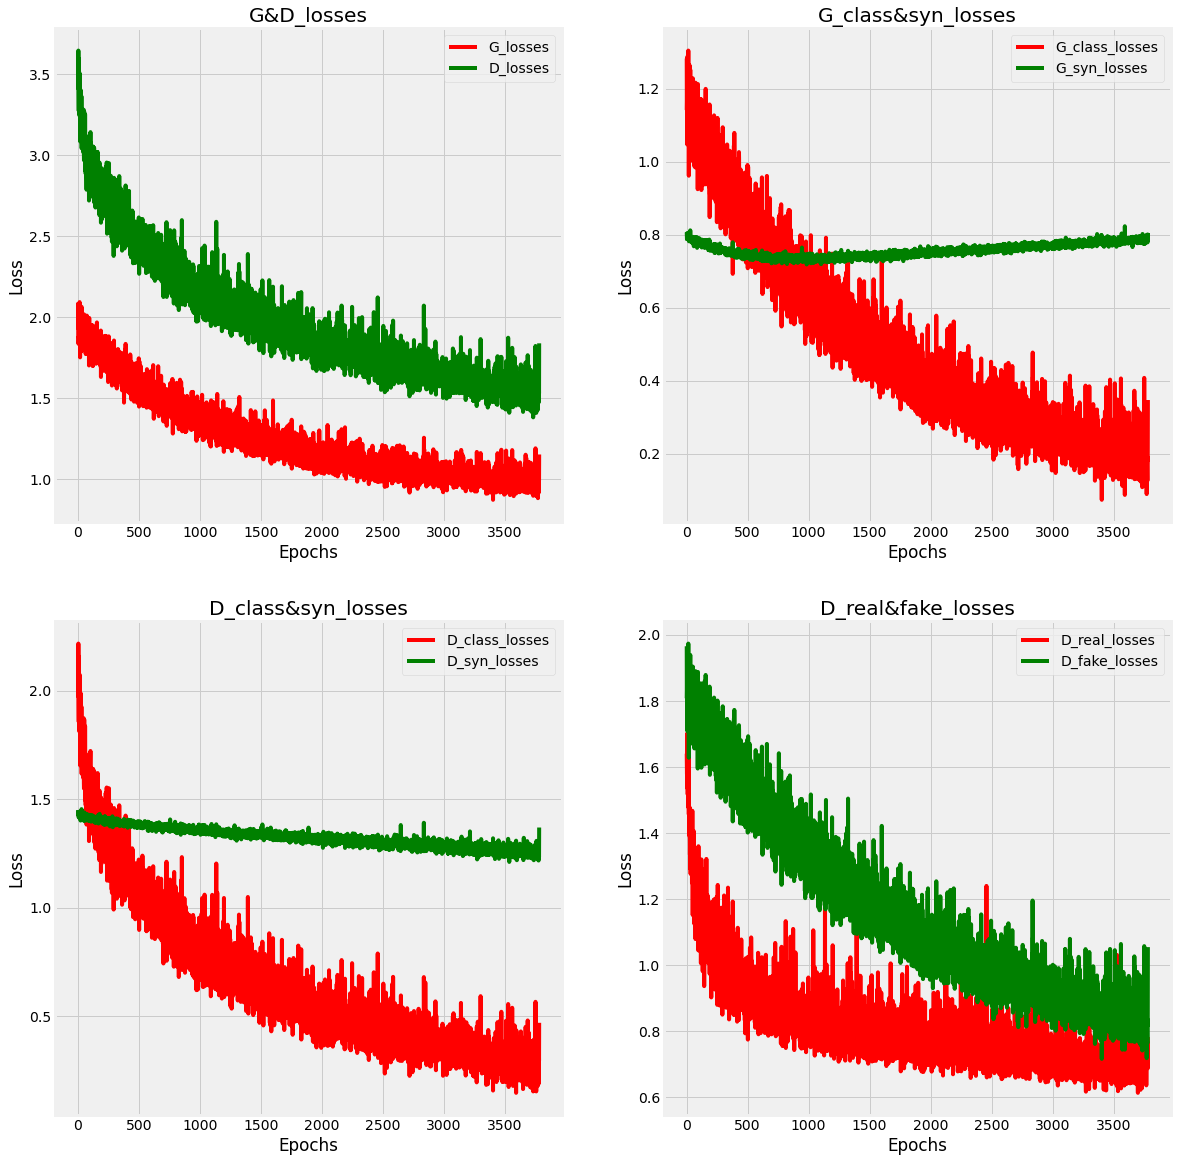

In [34]:
tr_plot(metrics, 0)

In [35]:
def tr_plot(tr_data, start_epoch):
    Epoch_count=len(metrics['Losses']) + start_epoch
    Epochs=[i + 1 for i in range (start_epoch ,Epoch_count)]  
    plt.figure(figsize=(20, 10))
    plt.style.use('fivethirtyeight')
    
    plt.subplot(2, 2, 1)
    plt.plot(Epochs, metrics['Losses'], 'blue', label='Loss')
    plt.title('Losses')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(2, 2, 2)
    plt.plot(Epochs, metrics['Accuracy'], 'orange', label='Accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout
    plt.show()

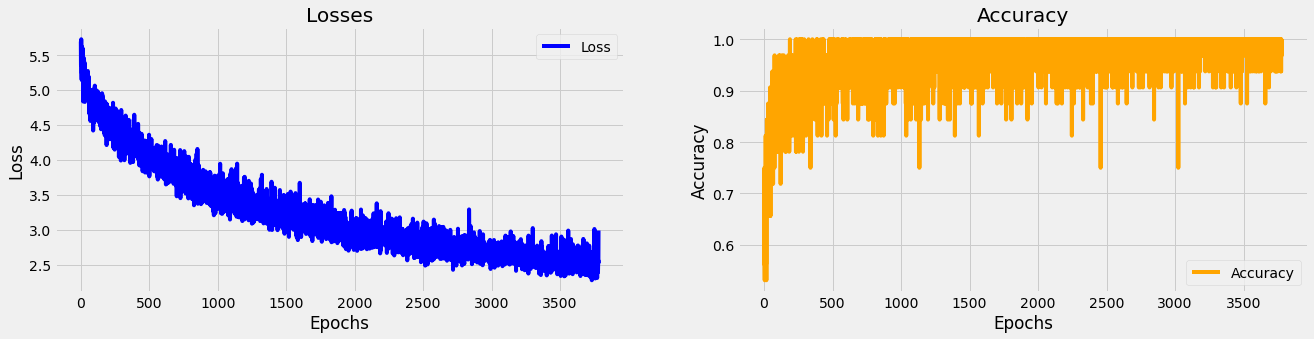

In [36]:
tr_plot(metrics, 0)

In [37]:
def test_gan(generator, discriminator, num_epochs, metrics, loader):
    now = datetime.datetime.now()
    g_losses = metrics['G_losses'][-1]
    d_losses = metrics['D_losses'][-1]
    path='GANAug/output_images/ACGAN'
    try:
        os.mkdir(os.path.join('.', path))
    except Exception as error:
        print(error)

    real_batch = next(iter(loader))
    
    test_img_list = []
    test_noise = torch.randn(batch_size, nz, device=device)
    test_label = torch.randn(batch_size, nb_label, device=device)
    test_fake = generator(test_noise, test_label).detach().cpu()
    test_img_list.append(vutils.make_grid(test_fake, padding=2, normalize=True))

    fig = plt.figure(figsize=(20, 20))
    ax1 = plt.subplot(1,2,1)
    ax1 = plt.axis("off")
    ax1 = plt.title("Real Images")
    ax1 = plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

    ax2 = plt.subplot(1,2,2)
    ax2 = plt.axis("off")
    ax2 = plt.title("Fake Images")
    ax2 = plt.imshow(np.transpose(test_img_list[-1],(1,2,0)))
    plt.show()
    fig.savefig('%s/image_%.3f_%.3f_%d_%s.png' %
                   (path, g_losses, d_losses, num_epochs, now.strftime("%Y-%m-%d_%H:%M:%S")))

[Errno 17] File exists: './GANAug/output_images/ACGAN'


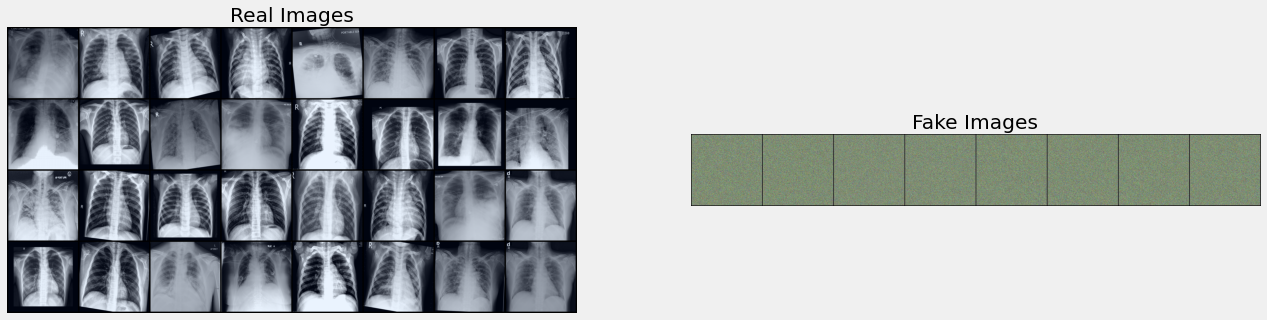

In [38]:
test_gan(generator, discriminator, num_epochs, metrics, train_loader)

In [39]:
def plot_gan(name, train_epoch, values, path, save):
    clear_output(wait=True)
    plt.close('all')
    fig = plt.figure()
    fig = plt.ion()
    fig = plt.subplot(1, 1, 1)
    fig = plt.title('epoch: %s -> %s: %s' % (train_epoch, name, values[-1]))
    fig = plt.ylabel(name)
    fig = plt.xlabel('train_set')
    fig = plt.plot(values)
    fig = plt.grid()
    get_fig = plt.gcf()
    fig = plt.draw()  # draw the plot
    fig = plt.pause(1)  # show it for 1 second
    plt.show()
    if save:
        now = datetime.datetime.now()
        get_fig.savefig('%s/%s_%.3f_%d_%s.png' %
                        (path, name, train_epoch, values[-1], now.strftime("%Y-%m-%d_%H:%M:%S")))

In [40]:
def save_model(generator, discriminator, gen_optimizer, dis_optimizer, metrics, num_epochs):
    now = datetime.datetime.now()
    g_losses = metrics['G_losses'][-1]
    d_losses = metrics['D_losses'][-1]
    path='GANAug/plots/ACGAN/train_%+.3f_%+.3f_%s'% (g_losses, d_losses, now.strftime("%Y-%m-%d_%H-%M-%S"))
    try:
        os.mkdir(os.path.join('.', path))
    except Exception as error:
        print(error)
    plot_gan('G_losses', num_epochs, metrics['G_losses'], path, True)
    plot_gan('D_losses', num_epochs, metrics['D_losses'], path, True)
    plot_gan('G_syn_losses', num_epochs, metrics['G_syn_losses'], path, True)
    plot_gan('G_class_losses', num_epochs, metrics['G_class_losses'], path, True)
    plot_gan('G_syn_losses', num_epochs, metrics['G_syn_losses'], path, True)
    plot_gan('D_class_losses', num_epochs, metrics['D_class_losses'], path, True)
    plot_gan('D_syn_losses', num_epochs, metrics['D_syn_losses'], path, True)
    plot_gan('Losses', num_epochs, metrics['Losses'], path, True)
    plot_gan('Accuracy', num_epochs, metrics['Accuracy'], path, True)

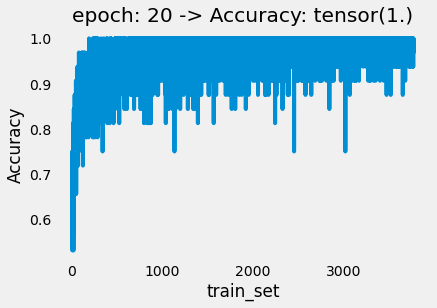

In [41]:
save_model(generator, discriminator, optimizerG, optimizerD, metrics, num_epochs)

Discriminator s tensor([[0.5452],
        [0.4441],
        [0.4717],
        [0.4856],
        [0.4044],
        [0.4550],
        [0.4344],
        [0.4264]], device='cuda:0', grad_fn=<SigmoidBackward0>)
Discriminator c tensor([[ 3.1268, -7.2143,  5.2010],
        [ 0.8244, -0.7780,  0.1496],
        [-0.7932,  2.5146, -1.9153],
        [ 1.8847, -1.1187, -1.6693],
        [-0.7880, -0.7563,  1.1078],
        [ 0.1288, -0.5197,  0.3761],
        [-1.7311,  6.8833, -6.3243],
        [-1.9908,  0.6046,  2.0490]], device='cuda:0',
       grad_fn=<AddmmBackward0>)


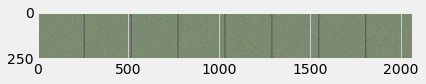

In [42]:
test_img_list = []
test_noise = torch.randn(batch_size, nz, device=device)
test_label = torch.randn(batch_size, nb_label, device=device)
test_img = generator(test_noise, test_label)

s_output, c_label_op = discriminator(test_img.detach().to(device))
print('Discriminator s', s_output)
print('Discriminator c', c_label_op)

test_img = test_img.detach().cpu()
test_img_list.append(vutils.make_grid(test_img, padding=2, normalize=True))
plt.imshow(np.transpose(test_img_list[-1],(1,2,0)))

class label for real tensor([2, 2, 1, 1, 2, 2, 2, 0, 0, 2, 0, 0, 2, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 2,
        1, 0, 1, 2, 1, 2, 2, 0])
Discriminator s tensor([[0.5358],
        [0.5330],
        [0.4357],
        [0.4070],
        [0.4193],
        [0.4723],
        [0.5076],
        [0.4352],
        [0.7480],
        [0.3205],
        [0.5741],
        [0.5330],
        [0.5032],
        [0.7001],
        [0.5215],
        [0.6866],
        [0.6261],
        [0.6935],
        [0.4292],
        [0.3217],
        [0.4940],
        [0.6415],
        [0.4968],
        [0.3200],
        [0.4933],
        [0.5228],
        [0.4626],
        [0.5025],
        [0.5498],
        [0.3120],
        [0.5315],
        [0.6274]], device='cuda:0', grad_fn=<SigmoidBackward0>)
Discriminator c tensor([[-4.6990,  1.0106,  4.0268],
        [-6.0692,  2.6017,  3.5440],
        [-1.3012,  1.4842, -0.0621],
        [-4.5295,  2.6397,  1.7013],
        [-0.3488,  0.1232, -0.1206],
        [-1.3108, -0.5562, 

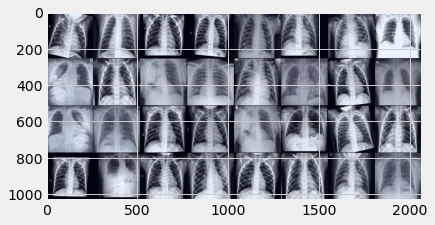

In [43]:
data = next(iter(test_loader))
test_noise, test_class_lable = data
test_img = test_noise
print('class label for real', test_class_lable)

s_output,c_label_op = discriminator(test_img.detach().to(device))
print('Discriminator s', s_output)
print('Discriminator c', c_label_op)

test_img = test_img.detach().cpu()
test_img_list.append(vutils.make_grid(test_img, padding=2, normalize=True))
plt.imshow(np.transpose(test_img_list[-1],(1,2,0)))